# option implied VaR and CVaR


## VaR
**1. 风险价值 (Value at Risk, VaR)**

- **概念：** VaR 是指在**正常市场条件**下，给定一定的**置信水平**（Confidence Level）和一定的**持有期**（Time Horizon），一项投资或一个投资组合预期可能发生的最大损失值。
- **通俗解释：** 假设你管理一个投资组合，你想知道在接下来的1天内，有95%的可能性，你的最大损失不会超过多少钱。这个“多少钱”就是置信水平为95%、持有期为1天的VaR。
  - 换句话说，VaR 回答的是：“在给定的概率下，我的损失不会超过多少？” 或者 “我有 X% 的把握，在未来 N 天内，我的损失不会超过 V 元。”
- **计算公式**：
  $$ \mathrm{VaR}_{t,T}^{\alpha} = S_t - K^{\alpha} $$

- **通过看跌期权反解置信水平：**
  $$p_t = e^{-r_{t,T} \cdot T} \int_0^K (K - S_t) f(S_{t,T}) \mathrm{d}S_{t,T}$$
  对K求导可得：
  $$\begin{align*}
  \frac{dp_t}{dK} &= e^{-r_{t,T} \cdot T} \int_0^K f(S_{t,T}) dS_{t,T} \\
  &= e^{-r_{t,T} \cdot T} F(K) \\
  &= e^{-r_{t,T} \cdot T} \alpha.
  \end{align*}
  $$
  使用离散化求数值解：
  $$ \begin{align*}\alpha &= \frac{1}{2} \left[ \frac{dp^{\text{UP}}}{dK^{\text{UP}}} + \frac{dp^{\text{DOWN}}}{dK^{\text{DOWN}}} \right] \\&= \frac{1}{2} \left[ \frac{p_3 - p_2}{K_3 - K_2} + \frac{p_2 - p_1}{K_2 - K_1} \right]\end{align*}$$

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pandas as pd
from pandas.tseries.offsets import WeekOfMonth

ts.set_token(os.getenv("TS_TOKEN"))  # 设置token
pro = ts.pro_api()

### Scrip

In [60]:
optDf = pro.opt_basic(
    exchange="SSE",
    fields="ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg",
)
optDf

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg
0,10003652.SH,OP510300.SH,华泰柏瑞沪深300ETF期权2111认沽4.70,10000.0,P,4.700,20210923,20211124,0.0001
1,10004160.SH,OP510300.SH,华泰柏瑞沪深300ETF期权2209认购3.70,10000.0,C,3.700,20220316,20220928,0.0001
2,10009084.SH,OP510300.SH,华泰柏瑞沪深300ETF期权2505认沽4.20,10000.0,P,4.200,20250327,20250528,0.0001
3,10004964.SH,OP510300.SH,华泰柏瑞沪深300ETF期权2302认购4.135,10157.0,C,4.135,20221229,20230222,0.0001
4,10004190.SH,OP510300.SH,华泰柏瑞沪深300ETF期权2205认沽3.90,10000.0,P,3.900,20220324,20220525,0.0001
...,...,...,...,...,...,...,...,...,...
9309,10005912.SH,OP588000.SH,华夏上证科创板50ETF期权2403认沽0.70,10000.0,P,0.700,20230824,20240327,0.0001
9310,10008207.SH,OP588000.SH,华夏上证科创板50ETF期权2411认购1.30,10000.0,C,1.300,20241009,20241127,0.0001
9311,10009106.SH,OP588000.SH,华夏上证科创板50ETF期权2505认购0.95,10000.0,C,0.950,20250327,20250528,0.0001
9312,10009200.SH,OP588000.SH,华夏上证科创板50ETF期权2505认购0.80,10000.0,C,0.800,20250408,20250528,0.0001


In [61]:
# 筛选出上证50
optDf = optDf.loc[optDf.name.apply(lambda x: "上证50" in x)]
optDf

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg
2278,10000579.SH,OP510050.SH,华夏上证50ETF期权1604认购2.15,10000.0,C,2.150,20160225,20160427,0.0001
2279,10004284.SH,OP510050.SH,华夏上证50ETF期权2207认购2.70,10000.0,C,2.700,20220526,20220727,0.0001
2280,10004873.SH,OP510050.SH,华夏上证50ETF期权2301认沽2.65,10000.0,P,2.650,20221201,20230130,0.0001
2281,10003510.SH,OP510050.SH,华夏上证50ETF期权2107认沽2.90,10000.0,P,2.900,20210728,20210728,0.0001
2282,10000108.SH,OP510050.SH,华夏上证50ETF期权1505认购2.65,10000.0,C,2.650,20150326,20150527,0.0001
...,...,...,...,...,...,...,...,...,...
6817,10004869.SH,OP510050.SH,华夏上证50ETF期权2301认沽2.45,10000.0,P,2.450,20221201,20230130,0.0001
6818,10008365.SH,OP510050.SH,华夏上证50ETF期权2506认购3.136,10205.0,C,3.136,20241108,20250625,0.0001
6819,10008403.SH,OP510050.SH,华夏上证50ETF期权2501认沽2.646,10205.0,P,2.646,20241128,20250122,0.0001
6820,10000259.SH,OP510050.SH,华夏上证50ETF期权1507认沽2.65,10000.0,P,2.650,20150629,20150722,0.0001


In [62]:
# 筛选出看涨期权
optDfCall = optDf.loc[optDf.name.apply(lambda x: "认购" in x)]
optDfCall.sort_values(["delist_date", "exercise_price"], ascending=False, inplace=True)
optDfCall.head()

C:\Users\hxy23\AppData\Local\Temp\ipykernel_19920\3980443272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optDfCall.sort_values(["delist_date", "exercise_price"], ascending=False, inplace=True)


,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg
4745,10009311.SH,OP510050.SH,华夏上证50ETF期权2512认购2.95,10000.0,C,2.95,20250508,20251224,0.0001
6191,10009225.SH,OP510050.SH,华夏上证50ETF期权2512认购2.90,10000.0,C,2.90,20250424,20251224,0.0001
2414,10009224.SH,OP510050.SH,华夏上证50ETF期权2512认购2.85,10000.0,C,2.85,20250424,20251224,0.0001
5918,10009223.SH,OP510050.SH,华夏上证50ETF期权2512认购2.80,10000.0,C,2.80,20250424,20251224,0.0001
4289,10009222.SH,OP510050.SH,华夏上证50ETF期权2512认购2.75,10000.0,C,2.75,20250424,20251224,0.0001


In [64]:
# 筛选出看跌期权
optDfPut = optDf.loc[optDf.name.apply(lambda x: "认沽" in x)]
optDfPut.sort_values(["delist_date", "exercise_price"], ascending=False, inplace=True)
optDfPut.head()

C:\Users\hxy23\AppData\Local\Temp\ipykernel_19920\2479726294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optDfPut.sort_values(["delist_date", "exercise_price"], ascending=False, inplace=True)


,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg
4110,10009312.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.95,10000.0,P,2.95,20250508,20251224,0.0001
4762,10009234.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.90,10000.0,P,2.90,20250424,20251224,0.0001
4021,10009233.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.85,10000.0,P,2.85,20250424,20251224,0.0001
5826,10009232.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.80,10000.0,P,2.80,20250424,20251224,0.0001
6687,10009231.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.75,10000.0,P,2.75,20250424,20251224,0.0001


In [63]:
# 以20250424号为例（期权到期日，使用剩余一个月到期的期权进行VaR的计算）
tempDate = pd.to_datetime("20250424")
tempDate

Timestamp('2025-04-24 00:00:00')

In [65]:
# 转换时间戳数据类型
optDfPut.loc[:, ["list_date", "delist_date"]] = optDfPut.loc[
    :, ["list_date", "delist_date"]
].apply(lambda x: pd.to_datetime(x))
optDfPut = optDfPut.convert_dtypes()
optDfPut.head()

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg
4110,10009312.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.95,10000,P,2.95,2025-05-08,2025-12-24,0.0001
4762,10009234.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.90,10000,P,2.9,2025-04-24,2025-12-24,0.0001
4021,10009233.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.85,10000,P,2.85,2025-04-24,2025-12-24,0.0001
5826,10009232.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.80,10000,P,2.8,2025-04-24,2025-12-24,0.0001
6687,10009231.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.75,10000,P,2.75,2025-04-24,2025-12-24,0.0001


In [66]:
# 计算剩余到期月份，获得目标期权合约
optDfPut.loc[:, "remain"] = (optDfPut["delist_date"] - tempDate).apply(lambda x: x.days)
optDfPut

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg,remain
4110,10009312.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.95,10000,P,2.95,2025-05-08,2025-12-24,0.0001,244
4762,10009234.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.90,10000,P,2.9,2025-04-24,2025-12-24,0.0001,244
4021,10009233.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.85,10000,P,2.85,2025-04-24,2025-12-24,0.0001,244
5826,10009232.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.80,10000,P,2.8,2025-04-24,2025-12-24,0.0001,244
6687,10009231.SH,OP510050.SH,华夏上证50ETF期权2512认沽2.75,10000,P,2.75,2025-04-24,2025-12-24,0.0001,244
...,...,...,...,...,...,...,...,...,...,...
3381,10000010.SH,OP510050.SH,华夏上证50ETF期权1503认沽2.40,10000,P,2.4,2015-02-09,2015-03-25,0.0001,-3683
4518,10000009.SH,OP510050.SH,华夏上证50ETF期权1503认沽2.35,10000,P,2.35,2015-02-09,2015-03-25,0.0001,-3683
5779,10000008.SH,OP510050.SH,华夏上证50ETF期权1503认沽2.30,10000,P,2.3,2015-02-09,2015-03-25,0.0001,-3683
2667,10000007.SH,OP510050.SH,华夏上证50ETF期权1503认沽2.25,10000,P,2.25,2015-02-09,2015-03-25,0.0001,-3683


In [67]:
import pandas as pd
from pandas.tseries.offsets import WeekOfMonth


def get_third_friday(year, month):
    # 使用 WeekOfMonth 计算第三个星期五
    third_friday = pd.Timestamp(
        year=year, month=month, day=1
    ) + WeekOfMonth(  # 该月第一天
        week=3, weekday=2
    )  # week=3 表示第四个（0-based），weekday=2 是星期三
    return third_friday


# 获取 2025 年 4 月的第四个星期三
_2504third_friday = get_third_friday(2025, 4)
_2505third_friday = get_third_friday(2025, 5)
(_2505third_friday - _2504third_friday).days

35

In [87]:
tempDate.month

4

In [88]:
tempDate.year

2025

In [68]:
# 筛选出剩余一个月到期的期权合约
optDfPut = optDfPut.loc[
    optDfPut.loc[:, "remain"] == (_2505third_friday - _2504third_friday).days - 1
]
optDfPut

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg,remain
3390,10009068.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.95,10000,P,2.95,2025-03-27,2025-05-28,0.0001,34
3070,10009067.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.90,10000,P,2.9,2025-03-27,2025-05-28,0.0001,34
2285,10009066.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.85,10000,P,2.85,2025-03-27,2025-05-28,0.0001,34
4932,10009065.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.80,10000,P,2.8,2025-03-27,2025-05-28,0.0001,34
3452,10009064.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.75,10000,P,2.75,2025-03-27,2025-05-28,0.0001,34
5144,10009063.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.70,10000,P,2.7,2025-03-27,2025-05-28,0.0001,34
4495,10009062.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.65,10000,P,2.65,2025-03-27,2025-05-28,0.0001,34
5454,10009061.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.60,10000,P,2.6,2025-03-27,2025-05-28,0.0001,34
5784,10009060.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.55,10000,P,2.55,2025-03-27,2025-05-28,0.0001,34
4947,10009148.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.50,10000,P,2.5,2025-04-02,2025-05-28,0.0001,34


In [71]:
# 获取所有的日线信息
optDfDailyAll = pro.opt_daily(trade_date="20250424", exchange="SSE")
optDfDailyAll

,ts_code,trade_date,exchange,pre_settle,pre_close,open,high,low,close,settle,vol,amount,oi
0,10008261.SH,20250424,SSE,0.1792,0.1792,0.1852,0.1935,0.1784,0.1845,0.1835,105.0,20.245802,752.0
1,10008262.SH,20250424,SSE,0.1398,0.1398,0.1437,0.1518,0.1425,0.1444,0.1433,100.0,15.139015,753.0
2,10008263.SH,20250424,SSE,0.1026,0.1050,0.1069,0.1150,0.1023,0.1060,0.1070,257.0,28.639414,3822.0
3,10008264.SH,20250424,SSE,0.0739,0.0739,0.0765,0.0828,0.0714,0.0757,0.0757,890.0,70.314899,1513.0
4,10008265.SH,20250424,SSE,0.0506,0.0517,0.0530,0.0570,0.0490,0.0532,0.0523,910.0,48.886032,1830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,10009302.SH,20250424,SSE,0.1290,NaN,0.1289,0.1318,0.1289,0.1289,0.1298,6.0,0.780000,6.0
530,10009303.SH,20250424,SSE,0.1675,NaN,0.1681,0.1681,0.1643,0.1643,0.1693,11.0,1.845300,10.0
531,10009304.SH,20250424,SSE,0.2070,NaN,NaN,NaN,NaN,0.2070,0.2088,0.0,0.000000,0.0
532,10009305.SH,20250424,SSE,0.2505,NaN,NaN,NaN,NaN,0.2505,0.2508,0.0,0.000000,0.0


In [73]:
optDfDailyPut = optDfDailyAll[optDfDailyAll.ts_code.isin(optDfPut.ts_code)]
optDfDailyPut

,ts_code,trade_date,exchange,pre_settle,pre_close,open,high,low,close,settle,vol,amount,oi
313,10009060.SH,20250424,SSE,0.0090,0.0090,0.0090,0.0090,0.0065,0.0078,0.0078,10627.0,79.3345,26699.0
314,10009061.SH,20250424,SSE,0.0148,0.0148,0.0144,0.0144,0.0101,0.0123,0.0123,32638.0,381.1127,51943.0
315,10009062.SH,20250424,SSE,0.0249,0.0249,0.0253,0.0255,0.0191,0.0226,0.0226,40239.0,871.6656,48112.0
316,10009063.SH,20250424,SSE,0.0434,0.0434,0.0430,0.0434,0.0336,0.0389,0.0389,86642.0,3307.6340,64741.0
317,10009064.SH,20250424,SSE,0.0719,0.0719,0.0730,0.0730,0.0578,0.0649,0.0649,51065.0,3268.1121,39569.0
318,10009065.SH,20250424,SSE,0.1087,0.1087,0.1069,0.1080,0.0923,0.1022,0.1022,11093.0,1106.3015,7841.0
319,10009066.SH,20250424,SSE,0.1523,0.1523,0.1497,0.1518,0.1343,0.1459,0.1459,1807.0,256.1838,4435.0
320,10009067.SH,20250424,SSE,0.1981,0.1981,0.1903,0.1965,0.1808,0.1920,0.1920,293.0,55.3287,1670.0
321,10009068.SH,20250424,SSE,0.2475,0.2475,0.2450,0.2460,0.2290,0.2397,0.2397,220.0,52.4185,1480.0
399,10009148.SH,20250424,SSE,0.0064,0.0064,0.0058,0.0063,0.0045,0.0054,0.0054,7119.0,37.3841,27273.0


In [77]:
optDfPut = optDfPut.merge(optDfDailyPut, on="ts_code")
optDfPut.head()

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg,remain,...,pre_settle,pre_close,open,high,low,close,settle,vol,amount,oi
0,10009068.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.95,10000,P,2.95,2025-03-27,2025-05-28,0.0001,34,...,0.2475,0.2475,0.2450,0.2460,0.2290,0.2397,0.2397,220.0,52.4185,1480.0
1,10009067.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.90,10000,P,2.9,2025-03-27,2025-05-28,0.0001,34,...,0.1981,0.1981,0.1903,0.1965,0.1808,0.1920,0.1920,293.0,55.3287,1670.0
2,10009066.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.85,10000,P,2.85,2025-03-27,2025-05-28,0.0001,34,...,0.1523,0.1523,0.1497,0.1518,0.1343,0.1459,0.1459,1807.0,256.1838,4435.0
3,10009065.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.80,10000,P,2.8,2025-03-27,2025-05-28,0.0001,34,...,0.1087,0.1087,0.1069,0.1080,0.0923,0.1022,0.1022,11093.0,1106.3015,7841.0
4,10009064.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.75,10000,P,2.75,2025-03-27,2025-05-28,0.0001,34,...,0.0719,0.0719,0.0730,0.0730,0.0578,0.0649,0.0649,51065.0,3268.1121,39569.0


In [83]:
sz50etf = pro.fund_daily(
    ts_code="510050.SH", start_date="20250424", end_date="20250424"
)
sz50etf

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,amount
0,510050.SH,20250424,2.708,2.708,2.726,2.707,2.715,0.007,0.2585,5941611.05,1613866.464


In [95]:
sz50etf.close[0]

np.float64(2.715)

In [84]:
shibor = pro.shibor(start_date="20250424", end_date="20250424")
shibor

,date,on,1w,2w,1m,3m,6m,9m,1y
0,20250424,1.61,1.69,1.767,1.747,1.75,1.764,1.766,1.766


In [96]:
shibor["1m"]

0    1.747
Name: 1m, dtype: float64

### main

In [11]:
def get_date(year, month, week=4, weekday=3):
    # 使用 WeekOfMonth 计算第四个星期三
    forth_thursday = pd.Timestamp(
        year=year, month=month, day=1
    ) + WeekOfMonth(  # 该月第一天
        week=week - 1, weekday=weekday - 1
    )  # week=3 表示第四个（0-based），weekday=2 是星期三
    return forth_thursday


def get_option(
    ts_pro,
    exchange="SSE",
    fields="ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg",
    option="上证50",
    S0Code="510050.SH",
    date="20250424",
):
    tempDate = pd.to_datetime(date)
    # 获取期权合约信息
    optDf = ts_pro.opt_basic(
        exchange=exchange,
        fields=fields,
    )
    # 筛选出目标期权
    optDf = optDf.loc[optDf.name.apply(lambda x: option in x)]
    # 转换时间戳数据类型
    optDf.loc[:, ["list_date", "delist_date"]] = optDf.loc[
        :, ["list_date", "delist_date"]
    ].apply(lambda x: pd.to_datetime(x))
    optDf = optDf.convert_dtypes()
    # 计算剩余到期月份，获得目标期权合约
    optDf.loc[:, "remain"] = (optDf["delist_date"] - tempDate).apply(lambda x: x.days)

    # 最近一个到期月期权剩余天数
    latest_remain_days = (
        get_date(tempDate.year, tempDate.month + 1)
        - get_date(tempDate.year, tempDate.month)
    ).days - 1

    optDf = optDf.loc[optDf.loc[:, "remain"] == latest_remain_days]
    optDf = optDf.sort_values(["call_put", "exercise_price"])

    # 获取行情数据
    optDfDailyAll = pro.opt_daily(trade_date=date, exchange=exchange)
    # 筛选期权
    optDfDailyAll = optDfDailyAll[optDfDailyAll.ts_code.isin(optDf.ts_code)]
    optDf = optDf.merge(optDfDailyAll, on="ts_code")

    # 获取标的资产的价格
    optDf["s0"] = pro.fund_daily(ts_code=S0Code, start_date=date, end_date=date).close[
        0
    ]
    optDf["shibor_1m"] = (
        pro.shibor(start_date="20250424", end_date="20250424")["1m"][0] / 100
    )

    optDf["trade_date"] = pd.to_datetime(optDf["trade_date"])
    optDf["ttm"] = (optDf.delist_date - optDf.trade_date).apply(lambda x: x.days) / 365
    return optDf


def option_clean(
    optDf,
    required_cols=[
        "call_put",
        "exercise_price",
        "delist_date",
        "trade_date",
        "close",
        "vol",
        "s0",
        "shibor_1m",
        "ttm",
    ],
):
    # 数据预处理
    print(f"开始筛选数据，初始条数: {len(optDf)}")
    data_filtered = optDf.copy()

    # 确保必要列存在
    missing_cols = [col for col in required_cols if col not in data_filtered.columns]
    if missing_cols:
        raise ValueError(f"输入DataFrame缺少必要列: {missing_cols}")

    # 删除必要列中的缺失值 (NaN)
    original_count = len(data_filtered)
    data_filtered.dropna(subset=required_cols, inplace=True)
    print(
        f"删除缺失值后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
    )

    # 确保数值类型正确，错误的值转为NaN再删除
    numeric_cols = ["exercise_price", "close", "vol", "s0", "shibor_1m", "ttm"]
    for col in numeric_cols:
        data_filtered[col] = pd.to_numeric(data_filtered[col], errors="coerce")
    original_count = len(data_filtered)
    data_filtered.dropna(subset=numeric_cols, inplace=True)  # 删除因类型转换产生的NaN
    if original_count > len(data_filtered):
        print(
            f"删除无效数值后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # 筛选看涨 ('C') 和看跌 ('P') 期权，假设这是你的数据约定
    # 如果你的 'call_put' 列使用其他标识 (如 1/0)，请相应修改
    valid_option_types = ["C", "P"]  # 或者 [1, 0] 等
    original_count = len(data_filtered)
    data_filtered = data_filtered[data_filtered["call_put"].isin(valid_option_types)]
    if original_count > len(data_filtered):
        print(
            f"筛选期权类型 ('C'/'P') 后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # --- 1. 基于流动性和价格的简单过滤 ---
    min_volume = 100  # 最小成交量 (论文中可能使用更高阈值，如10，根据实际情况调整)
    min_price = 0.0001  # 最小期权价格 (例如，避免价格过低带来的噪音，单位与'close'一致)

    original_count = len(data_filtered)
    # 筛选成交量
    data_filtered = data_filtered[data_filtered["vol"] >= min_volume]
    # 筛选价格
    data_filtered = data_filtered[data_filtered["close"] >= min_price]
    if original_count > len(data_filtered):
        print(
            f"基于最小成交量(>={min_volume})和最小价格(>={min_price})筛选后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # --- 2. 基于到期时间的过滤 ---
    # 论文通常会排除临近到期和远期合约
    min_ttm_days = 7  # 最小剩余天数 (例如，排除最后一周，避免gamma风险和展期效应)
    max_ttm_days = 365  # 最大剩余天数 (例如，排除超过一年的，流动性可能较差)

    # 假设 ttm 列的单位是年，转换为天数进行比较
    data_filtered["ttm_days"] = data_filtered["ttm"] * 365
    original_count = len(data_filtered)
    data_filtered = data_filtered[
        (data_filtered["ttm_days"] >= min_ttm_days)
        & (data_filtered["ttm_days"] <= max_ttm_days)
    ]
    if original_count > len(data_filtered):
        print(
            f"基于到期时间 ({min_ttm_days}-{max_ttm_days} 天) 筛选后剩余条数: {len(data_filtered)} (移除了 {original_count - len(data_filtered)} 条)"
        )

    # --- 3. 基于无套利条件的过滤 ---
    # 这一步对于保证后续计算的稳定性至关重要

    # 3.1 检查内在价值下限 (期权价格不能低于其内在价值)
    # C >= max(0, S0 - K * exp(-r*T))
    # P >= max(0, K * exp(-r*T) - S0)

    discount_factor = np.exp(-data_filtered["shibor_1m"] * data_filtered["ttm"])
    call_violation = (data_filtered.call_put == "C") & (
        data_filtered.close
        > np.maximum(
            data_filtered["s0"] - data_filtered["exercise_price"] * discount_factor, 0
        )
    )
    put_violation = (data_filtered.call_put == "P") & (
        data_filtered.close
        > np.maximum(
            0, data_filtered["exercise_price"] * discount_factor - data_filtered["s0"]
        )
    )

    original_count = len(data_filtered)
    data_filtered = data_filtered[(call_violation | put_violation)]
    removed_count = original_count - len(data_filtered)
    if removed_count > 0:
        print(
            f"移除违反内在价值下限的期权后剩余条数: {len(data_filtered)} (移除了 {removed_count} 条)"
        )
    return data_filtered

In [12]:
optDf = get_option(pro)
optDf

,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg,remain,...,high,low,close,settle,vol,amount,oi,s0,shibor_1m,ttm
0,10009155.SH,OP510050.SH,华夏上证50ETF期权2505认购2.35,10000,C,2.35,2025-04-08,2025-05-28,0.0001,34,...,0.3753,0.3580,0.3674,0.3650,68.0,25.0892,486.0,2.715,0.01747,0.093151
1,10009156.SH,OP510050.SH,华夏上证50ETF期权2505认购2.40,10000,C,2.4,2025-04-08,2025-05-28,0.0001,34,...,0.3240,0.3080,0.3150,0.3150,78.0,24.8581,273.0,2.715,0.01747,0.093151
2,10009157.SH,OP510050.SH,华夏上证50ETF期权2505认购2.45,10000,C,2.45,2025-04-08,2025-05-28,0.0001,34,...,0.2750,0.2600,0.2648,0.2650,59.0,15.7726,559.0,2.715,0.01747,0.093151
3,10009147.SH,OP510050.SH,华夏上证50ETF期权2505认购2.50,10000,C,2.5,2025-04-02,2025-05-28,0.0001,34,...,0.2283,0.2110,0.2170,0.2170,941.0,205.7281,4874.0,2.715,0.01747,0.093151
4,10009051.SH,OP510050.SH,华夏上证50ETF期权2505认购2.55,10000,C,2.55,2025-03-27,2025-05-28,0.0001,34,...,0.1807,0.1631,0.1689,0.1689,2687.0,463.9787,5685.0,2.715,0.01747,0.093151
5,10009052.SH,OP510050.SH,华夏上证50ETF期权2505认购2.60,10000,C,2.6,2025-03-27,2025-05-28,0.0001,34,...,0.1349,0.1186,0.1247,0.1247,9135.0,1162.1232,9354.0,2.715,0.01747,0.093151
6,10009053.SH,OP510050.SH,华夏上证50ETF期权2505认购2.65,10000,C,2.65,2025-03-27,2025-05-28,0.0001,34,...,0.0931,0.0776,0.0845,0.0845,31924.0,2755.1042,23530.0,2.715,0.01747,0.093151
7,10009054.SH,OP510050.SH,华夏上证50ETF期权2505认购2.70,10000,C,2.7,2025-03-27,2025-05-28,0.0001,34,...,0.0583,0.0474,0.0520,0.0520,80732.0,4282.4317,56662.0,2.715,0.01747,0.093151
8,10009055.SH,OP510050.SH,华夏上证50ETF期权2505认购2.75,10000,C,2.75,2025-03-27,2025-05-28,0.0001,34,...,0.0325,0.0260,0.0284,0.0284,70221.0,2065.6026,59920.0,2.715,0.01747,0.093151
9,10009056.SH,OP510050.SH,华夏上证50ETF期权2505认购2.80,10000,C,2.8,2025-03-27,2025-05-28,0.0001,34,...,0.0168,0.0134,0.0147,0.0147,38588.0,589.0473,45779.0,2.715,0.01747,0.093151


In [13]:
data_filtered = option_clean(optDf)
data_filtered

开始筛选数据，初始条数: 26
删除缺失值后剩余条数: 26 (移除了 0 条)
基于最小成交量(>=100)和最小价格(>=0.0001)筛选后剩余条数: 23 (移除了 3 条)
移除违反内在价值下限的期权后剩余条数: 21 (移除了 2 条)


,ts_code,opt_code,name,per_unit,call_put,exercise_price,list_date,delist_date,min_price_chg,remain,...,low,close,settle,vol,amount,oi,s0,shibor_1m,ttm,ttm_days
5,10009052.SH,OP510050.SH,华夏上证50ETF期权2505认购2.60,10000,C,2.6,2025-03-27,2025-05-28,0.0001,34,...,0.1186,0.1247,0.1247,9135.0,1162.1232,9354.0,2.715,0.01747,0.093151,34.0
6,10009053.SH,OP510050.SH,华夏上证50ETF期权2505认购2.65,10000,C,2.65,2025-03-27,2025-05-28,0.0001,34,...,0.0776,0.0845,0.0845,31924.0,2755.1042,23530.0,2.715,0.01747,0.093151,34.0
7,10009054.SH,OP510050.SH,华夏上证50ETF期权2505认购2.70,10000,C,2.7,2025-03-27,2025-05-28,0.0001,34,...,0.0474,0.0520,0.0520,80732.0,4282.4317,56662.0,2.715,0.01747,0.093151,34.0
8,10009055.SH,OP510050.SH,华夏上证50ETF期权2505认购2.75,10000,C,2.75,2025-03-27,2025-05-28,0.0001,34,...,0.0260,0.0284,0.0284,70221.0,2065.6026,59920.0,2.715,0.01747,0.093151,34.0
9,10009056.SH,OP510050.SH,华夏上证50ETF期权2505认购2.80,10000,C,2.8,2025-03-27,2025-05-28,0.0001,34,...,0.0134,0.0147,0.0147,38588.0,589.0473,45779.0,2.715,0.01747,0.093151,34.0
10,10009057.SH,OP510050.SH,华夏上证50ETF期权2505认购2.85,10000,C,2.85,2025-03-27,2025-05-28,0.0001,34,...,0.0076,0.0080,0.0080,14394.0,120.9452,34407.0,2.715,0.01747,0.093151,34.0
11,10009058.SH,OP510050.SH,华夏上证50ETF期权2505认购2.90,10000,C,2.9,2025-03-27,2025-05-28,0.0001,34,...,0.0045,0.0050,0.0050,7260.0,37.5089,23113.0,2.715,0.01747,0.093151,34.0
12,10009059.SH,OP510050.SH,华夏上证50ETF期权2505认购2.95,10000,C,2.95,2025-03-27,2025-05-28,0.0001,34,...,0.0033,0.0033,0.0033,8660.0,31.0571,26866.0,2.715,0.01747,0.093151,34.0
13,10009158.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.35,10000,P,2.35,2025-04-08,2025-05-28,0.0001,34,...,0.0019,0.0024,0.0024,6471.0,14.8169,16286.0,2.715,0.01747,0.093151,34.0
14,10009159.SH,OP510050.SH,华夏上证50ETF期权2505认沽2.40,10000,P,2.4,2025-04-08,2025-05-28,0.0001,34,...,0.0022,0.0027,0.0027,3224.0,8.2894,9061.0,2.715,0.01747,0.093151,34.0


In [22]:
data_filtered_put = data_filtered[data_filtered.call_put == "P"][
    ["call_put", "exercise_price", "s0", "close", "shibor_1m", "ttm"]
]
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm
13,P,2.35,2.715,0.0024,0.01747,0.093151
14,P,2.4,2.715,0.0027,0.01747,0.093151
15,P,2.45,2.715,0.0035,0.01747,0.093151
16,P,2.5,2.715,0.0054,0.01747,0.093151
17,P,2.55,2.715,0.0078,0.01747,0.093151
18,P,2.6,2.715,0.0123,0.01747,0.093151
19,P,2.65,2.715,0.0226,0.01747,0.093151
20,P,2.7,2.715,0.0389,0.01747,0.093151
21,P,2.75,2.715,0.0649,0.01747,0.093151
22,P,2.8,2.715,0.1022,0.01747,0.093151


In [23]:
data_filtered_put["VaR"] = data_filtered_put.s0 - data_filtered_put.exercise_price
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR
13,P,2.35,2.715,0.0024,0.01747,0.093151,0.365
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085


In [24]:
data_filtered_put["p3-p2"] = (
    data_filtered_put.close - data_filtered_put.close.shift(1)
).shift(-1)
data_filtered_put["p2-p1"] = data_filtered_put.close - data_filtered_put.close.shift(1)
data_filtered_put["k3-k2"] = (
    data_filtered_put.exercise_price - data_filtered_put.exercise_price.shift(1)
).shift(-1)
data_filtered_put["k2-k1"] = (
    data_filtered_put.exercise_price - data_filtered_put.exercise_price.shift(1)
)
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1
13,P,2.35,2.715,0.0024,0.01747,0.093151,0.365,0.0003,NaN,0.05,<NA>
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05


In [81]:
data_filtered_put = data_filtered_put.dropna()
data_filtered_put.loc[:, "alpha"] = (
    np.exp(data_filtered_put["shibor_1m"] * data_filtered_put["ttm"])
    * (
        data_filtered_put["p3-p2"] / data_filtered_put["k3-k2"]
        - data_filtered_put["p2-p1"] / data_filtered_put["k2-k1"]
    )
    / 2
)
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha,CVaR,imp_vol,alpha_BS
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.005008,0.855879,0.230215,0.042713
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.011018,0.5837,0.208879,0.057152
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.005008,1.296759,0.194039,0.086366
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.021034,0.537034,0.174962,0.125599
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.058094,0.327414,0.158788,0.192470
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.060098,0.44228,0.152507,0.309476
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.097158,0.416684,0.145651,0.459219
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.113184,0.540272,0.144709,0.622518
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.064104,1.514476,0.156381,0.748493
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.024039,5.954068,0.175087,0.825060


## CVaR
**2. 条件风险价值 (Conditional Value at Risk, CVaR)**

- **概念：** CVaR 是指在损失**超过**VaR阈值的条件下，投资或投资组合的预期（平均）损失。
- **通俗解释：** 接着上面的例子，如果95% VaR是100万，意味着有5%的可能性损失会超过100万。CVaR回答的问题是：“如果那5%的不利情况真的发生了，平均来说我的损失会是多少？” 这个平均损失就是CVaR。

In [28]:
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.005
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.011
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.005
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.021
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.058
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.06
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.097
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.113
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.064
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.024


In [32]:
data_filtered_put.loc[:, "CVaR"] = (
    np.exp(data_filtered_put["shibor_1m"] * data_filtered_put["ttm"])
    * data_filtered_put.close
    / data_filtered_put.alpha
    + data_filtered_put.VaR
)
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha,CVaR
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.005,0.855879
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.011,0.5837
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.005,1.296759
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.021,0.537034
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.058,0.327414
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.06,0.44228
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.097,0.416684
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.113,0.540272
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.064,1.514476
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.024,5.954068


## 通过隐含波动率进行计算

In [46]:
from scipy.optimize import root, fsolve
from numpy import log, exp, sqrt
from scipy import stats
from scipy.optimize import fsolve


class European_option:

    def __init__(self, s0, exercise_price, ttm, shibor_1m, sigma, opt: str):
        self.s0 = s0
        self.exercise_price = exercise_price
        self.ttm = ttm
        self.shibor_1m = shibor_1m
        self.sigma = sigma
        self.opt = opt

    def value(self):
        d1 = (
            log(self.s0 / self.exercise_price)
            + (self.shibor_1m + 0.5 * self.sigma**2) * (self.ttm)
        ) / (self.sigma * sqrt(self.ttm))
        d2 = d1 - self.sigma * sqrt(self.ttm)
        if self.opt.upper() == "C":
            value = self.s0 * stats.norm.cdf(d1) - self.exercise_price * exp(
                -self.shibor_1m * (self.ttm)
            ) * stats.norm.cdf(d2)
        else:
            value = self.exercise_price * exp(
                -self.shibor_1m * (self.ttm)
            ) * stats.norm.cdf(-d2) - self.s0 * stats.norm.cdf(-d1)

        return value

    def imp_vol(self, C0, sigma_est=0.15):
        option = European_option(
            self.s0, self.exercise_price, self.ttm, self.shibor_1m, self.sigma, self.opt
        )

        def difference(sigma):
            option.sigma = sigma
            return option.value() - C0

        iv = fsolve(difference, sigma_est)[0]
        return iv


def calculate_iv(data):
    data.loc[:, "imp_vol"] = ""
    for row, option in data.iterrows():
        ttm = option["ttm"]
        shibor_1m = option["shibor_1m"]
        s0 = option["s0"]
        exercise_price = option["exercise_price"]
        sigma_estt = 0.15
        opt = option["call_put"]

        option_temp = European_option(
            s0, exercise_price, ttm, shibor_1m, sigma_estt, opt
        )

        V0 = option["close"]
        data.loc[row, "imp_vol"] = option_temp.imp_vol(V0)

    return data

In [50]:
data_filtered_put = calculate_iv(data_filtered_put)
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha,CVaR,imp_vol
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.005,0.855879,0.230215
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.011,0.5837,0.208879
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.005,1.296759,0.194039
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.021,0.537034,0.174962
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.058,0.327414,0.158788
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.06,0.44228,0.152507
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.097,0.416684,0.145651
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.113,0.540272,0.144709
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.064,1.514476,0.156381
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.024,5.954068,0.175087


In [75]:
d2 = (
    np.log(data_filtered_put.s0 / data_filtered_put.exercise_price)
    - data_filtered_put.imp_vol**2 * data_filtered_put.ttm / 2
) / (data_filtered_put.imp_vol * np.sqrt(data_filtered_put.ttm))
data_filtered_put["alpha_BS"] = 1 - pd.Series(
    map(stats.norm.cdf, d2), index=data_filtered_put.index
)
data_filtered_put

,call_put,exercise_price,s0,close,shibor_1m,ttm,VaR,p3-p2,p2-p1,k3-k2,k2-k1,alpha,CVaR,imp_vol,alpha_BS
14,P,2.4,2.715,0.0027,0.01747,0.093151,0.315,0.0008,0.0003,0.05,0.05,0.005,0.855879,0.230215,0.042713
15,P,2.45,2.715,0.0035,0.01747,0.093151,0.265,0.0019,0.0008,0.05,0.05,0.011,0.5837,0.208879,0.057152
16,P,2.5,2.715,0.0054,0.01747,0.093151,0.215,0.0024,0.0019,0.05,0.05,0.005,1.296759,0.194039,0.086366
17,P,2.55,2.715,0.0078,0.01747,0.093151,0.165,0.0045,0.0024,0.05,0.05,0.021,0.537034,0.174962,0.125599
18,P,2.6,2.715,0.0123,0.01747,0.093151,0.115,0.0103,0.0045,0.05,0.05,0.058,0.327414,0.158788,0.192470
19,P,2.65,2.715,0.0226,0.01747,0.093151,0.065,0.0163,0.0103,0.05,0.05,0.06,0.44228,0.152507,0.309476
20,P,2.7,2.715,0.0389,0.01747,0.093151,0.015,0.0260,0.0163,0.05,0.05,0.097,0.416684,0.145651,0.459219
21,P,2.75,2.715,0.0649,0.01747,0.093151,-0.035,0.0373,0.0260,0.05,0.05,0.113,0.540272,0.144709,0.622518
22,P,2.8,2.715,0.1022,0.01747,0.093151,-0.085,0.0437,0.0373,0.05,0.05,0.064,1.514476,0.156381,0.748493
23,P,2.85,2.715,0.1459,0.01747,0.093151,-0.135,0.0461,0.0437,0.05,0.05,0.024,5.954068,0.175087,0.825060


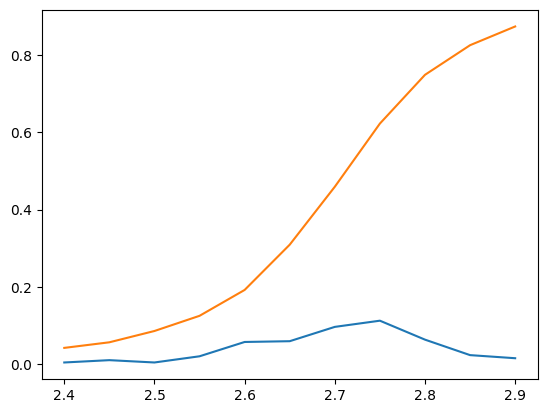

In [76]:
import matplotlib.pyplot as plt

plt.plot(data_filtered_put.exercise_price, data_filtered_put.alpha)
plt.plot(data_filtered_put.exercise_price, data_filtered_put.alpha_BS)